In [1]:
# ! pip install pandas seaborn matplotlib pyod scikit-learn numpy

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

## Load dataset

In [3]:
df = pd.read_csv('churn_data.csv', index_col='customerID')
df.tail()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
6840-RESVB,24,Yes,One year,Mailed check,84.80,1990.50,No
2234-XADUH,72,Yes,One year,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,11,No,Month-to-month,Electronic check,29.60,346.45,No
8361-LTMKD,4,Yes,Month-to-month,Mailed check,74.40,306.60,Yes
3186-AJIEK,66,Yes,Two year,Bank transfer (automatic),105.65,6844.50,No


## Filtering data

In [4]:
df['PhoneService'].value_counts()

PhoneService
Yes    6361
No      682
Name: count, dtype: int64

In [5]:
phoneservice_df = df[df['PhoneService'] == 'PhoneService']
phoneservice_df['PhoneService'].unique()

array([], dtype=object)

In [6]:
tenure_df = df[df['tenure'] <= 30]
tenure_df.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
9305-CDSKC,8,Yes,Month-to-month,Electronic check,99.65,820.50,Yes
1452-KIOVK,22,Yes,Month-to-month,Credit card (automatic),89.10,1949.40,No


## Checking for outliers

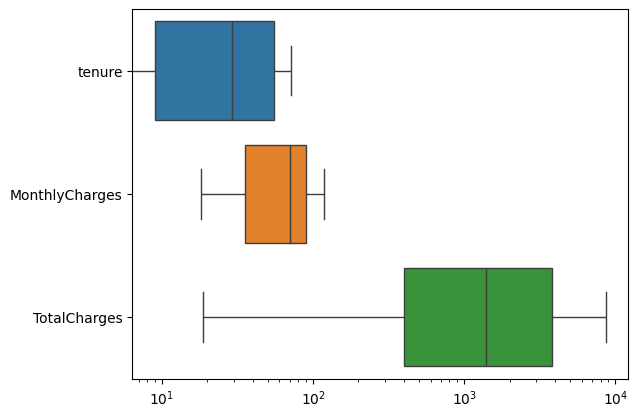

In [7]:
ax = sns.boxplot(data=df, orient='h')
ax.set_xscale("log")

In [8]:
# detect and handle outliers for a specific column
def handle_outliers(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_boundary = q3 + 1.5 * iqr
    lower_boundary = q1 - 1.5 * iqr
    
    outliers = df[(df[column] < lower_boundary) | (df[column] > upper_boundary)][column]
    df[column] = df[column].apply(lambda x: upper_boundary if x > upper_boundary else (lower_boundary if x < lower_boundary else x))
    
    return outliers


## Outliers for MonthlyCharges

In [9]:

outliers_monthly_charges = handle_outliers('MonthlyCharges')

print("Outliers in MonthlyCharges:")
outliers_monthly_charges


Outliers in MonthlyCharges:


Series([], Name: MonthlyCharges, dtype: float64)

## Outliers for TotalCharges

In [10]:
outliers_total_charges = handle_outliers('TotalCharges')

print("Outliers in TotalCharges:")
outliers_total_charges

Outliers in TotalCharges:


Series([], Name: TotalCharges, dtype: float64)

## Outliers in tenure

In [11]:
outliers_tenure = handle_outliers('MonthlyCharges')

print("Outliers in tenure:")
outliers_tenure

Outliers in tenure:


Series([], Name: MonthlyCharges, dtype: float64)

In [12]:
df_copy = df.copy()
df_copy['MonthlyCharges'].info()

<class 'pandas.core.series.Series'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Series name: MonthlyCharges
Non-Null Count  Dtype  
--------------  -----  
7043 non-null   float64
dtypes: float64(1)
memory usage: 110.0+ KB


In [13]:
df_copy = df.copy()
df_copy['TotalCharges'].info()

<class 'pandas.core.series.Series'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Series name: TotalCharges
Non-Null Count  Dtype  
--------------  -----  
7032 non-null   float64
dtypes: float64(1)
memory usage: 110.0+ KB


In [14]:
df_copy = df.copy()
df_copy['tenure'].info()

<class 'pandas.core.series.Series'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Series name: tenure
Non-Null Count  Dtype
--------------  -----
7043 non-null   int64
dtypes: int64(1)
memory usage: 110.0+ KB


In [15]:
df_copy = df.copy().reset_index()
df_copy.head()

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes


## Clipping outliers

In [ ]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'tenure'] 
columns = numeric_columns  # Change 'column' to 'columns' for clarity
q1 = df[columns].quantile(0.25)
q3 = df[columns].quantile(0.75)
iqr = q3 - q1
upper_boundary = q3 + 1.5 * iqr
lower_boundary = q1 - 1.5 * iqr

# Specify axis=1 when using clip on columns
df_copy[columns].clip(lower=lower_boundary, upper=upper_boundary, axis=1, inplace=True)


<Axes: >

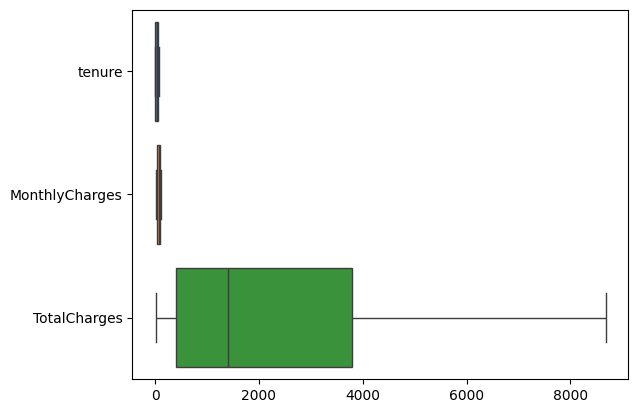

In [17]:
sns.boxplot(data=df_copy, orient='h')

## Missing values

In [18]:

missing = df.copy()

# Set tenure values to NaN where tenure is 30
missing.loc[missing['tenure'] == 30, 'tenure'] = np.nan

print("Count of missing values before dropping rows:")
missing.isna().sum()

Count of missing values before dropping rows:


tenure            72
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

# Drop rows with any missing values

In [19]:

missing.dropna(inplace=True)

print("\nCount of missing values after dropping rows:")
missing.isna().sum()


Count of missing values after dropping rows:


tenure            0
PhoneService      0
Contract          0
PaymentMethod     0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64

## Filling missing values

In [20]:

df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

## Separate missing values

In [21]:

df.loc[df['Churn'] == 1, 'TotalCharges'].fillna(df[df['Churn'] == 1]['TotalCharges'].median(), inplace=True)
df.loc[df['PhoneService'] == 0, 'MonthlyCharges'].fillna(df[df['PhoneService'] == 0]['MonthlyCharges'].median(), inplace=True)
df

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...
6840-RESVB,24,Yes,One year,Mailed check,84.80,1990.50,No
2234-XADUH,72,Yes,One year,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,11,No,Month-to-month,Electronic check,29.60,346.45,No


## Converting categorical columns to numeric 

In [22]:
df_copy['Churn'] = df_copy['Churn'].replace({'No': 0, 'Yes': 1})
df_copy['Churn'].value_counts()


Churn
0    5174
1    1869
Name: count, dtype: int64

In [23]:

df_copy['PhoneService'] = df_copy['PhoneService'].replace({'No': 0, 'Yes': 1})
df_copy['PhoneService'].value_counts()


PhoneService
1    6361
0     682
Name: count, dtype: int64

In [24]:
# check that all columns are numbers now
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   tenure          7043 non-null   int64  
 2   PhoneService    7043 non-null   int64  
 3   Contract        7043 non-null   object 
 4   PaymentMethod   7043 non-null   object 
 5   MonthlyCharges  7043 non-null   float64
 6   TotalCharges    7032 non-null   float64
 7   Churn           7043 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 440.3+ KB


In [25]:
df_copy

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,Month-to-month,Electronic check,29.85,29.85,0
1,5575-GNVDE,34,1,One year,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2,1,Month-to-month,Mailed check,53.85,108.15,1
3,7795-CFOCW,45,0,One year,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2,1,Month-to-month,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,One year,Mailed check,84.80,1990.50,0
7039,2234-XADUH,72,1,One year,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,11,0,Month-to-month,Electronic check,29.60,346.45,0
7041,8361-LTMKD,4,1,Month-to-month,Mailed check,74.40,306.60,1


## Feature Engineering

In [26]:
# Scaling data with a log transform for TotalCharges
df_copy['TotalCharges'] = np.log(df_copy['TotalCharges'])
df_copy



,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,Month-to-month,Electronic check,29.85,3.396185,0
1,5575-GNVDE,34,1,One year,Mailed check,56.95,7.544068,0
2,3668-QPYBK,2,1,Month-to-month,Mailed check,53.85,4.683519,1
3,7795-CFOCW,45,0,One year,Bank transfer (automatic),42.30,7.517928,0
4,9237-HQITU,2,1,Month-to-month,Electronic check,70.70,5.021575,1
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,One year,Mailed check,84.80,7.596141,0
7039,2234-XADUH,72,1,One year,Credit card (automatic),103.20,8.904209,0
7040,4801-JZAZL,11,0,Month-to-month,Electronic check,29.60,5.847739,0
7041,8361-LTMKD,4,1,Month-to-month,Mailed check,74.40,5.725544,1


## Plot histograms to visualize the effect of the log transform

<Axes: title={'center': 'Log-Transformed TotalCharges'}, ylabel='Frequency'>

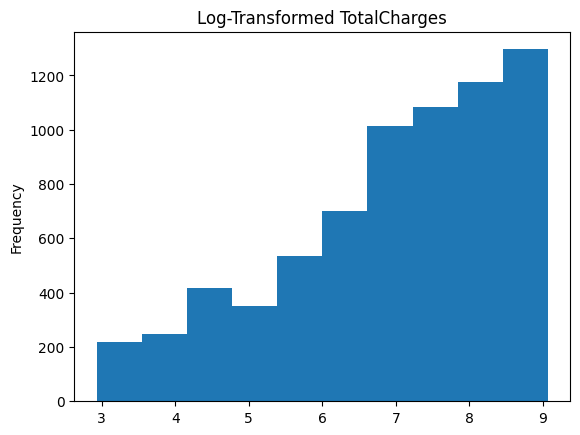

In [27]:

df_copy['TotalCharges'].plot.hist(title='Log-Transformed TotalCharges')



<Axes: title={'center': 'Original TotalCharges'}, ylabel='Frequency'>

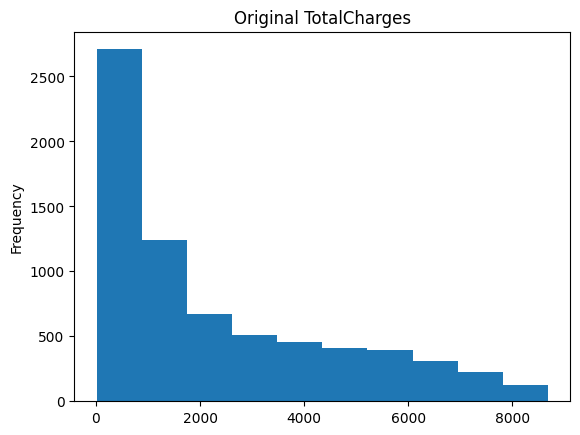

In [28]:

df['TotalCharges'].plot.hist(title='Original TotalCharges')

## Combine columns to create additional features

In [29]:

df_copy['MonthlyCharges_to_tenure_ratio'] = df_copy['MonthlyCharges'] / df_copy['tenure']

df['TotalCharges_to_MonthlyCharges_ratio'] = df['TotalCharges'] / df['MonthlyCharges']


## Plot histograms for the new features

<Axes: title={'center': 'TotalCharges/MonthlyCharges Ratio'}, ylabel='Frequency'>

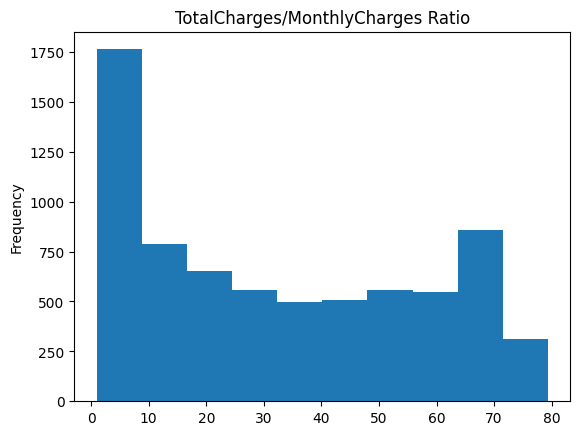

In [30]:
df['TotalCharges_to_MonthlyCharges_ratio'].plot.hist(title='TotalCharges/MonthlyCharges Ratio')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tenure                                7043 non-null   int64  
 1   PhoneService                          7043 non-null   object 
 2   Contract                              7043 non-null   object 
 3   PaymentMethod                         7043 non-null   object 
 4   MonthlyCharges                        7043 non-null   float64
 5   TotalCharges                          7043 non-null   float64
 6   Churn                                 7043 non-null   object 
 7   TotalCharges_to_MonthlyCharges_ratio  7043 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 495.2+ KB


In [32]:
df['customerID'] = range(1, len(df_copy) + 1)

## Save data

In [33]:

df.to_csv('preped_churn_data.csv', index=False)

## Advanced outlier detection

In [34]:
numeric_df = df.select_dtypes(exclude=['object'])

<Axes: >

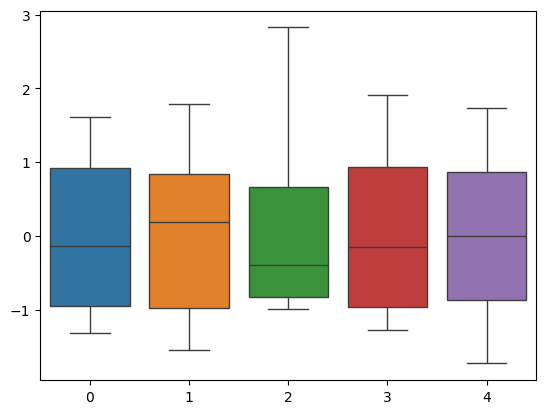

In [35]:
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_df)

sns.boxplot(data = scaled_numeric)

In [36]:
od = KNN(contamination=0.01)
od.fit(scaled_numeric)

outliers = od.predict(scaled_numeric)
outliers

outliers.sum()

df[outliers.astype('bool')]

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_MonthlyCharges_ratio,customerID
customerID,,,,,,,,,
7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.750,No,43.516548,4
0526-SXDJP,72,No,Two year,Bank transfer (automatic),42.10,2962.000,No,70.356295,63
3445-HXXGF,58,No,Month-to-month,Electronic check,45.30,2651.200,Yes,58.525386,169
4472-LVYGI,0,No,Two year,Bank transfer (automatic),52.55,1397.475,No,26.593245,489
4374-YMUSQ,34,Yes,One year,Credit card (automatic),116.25,3899.050,No,33.540215,501
5760-IFJOZ,3,Yes,Month-to-month,Mailed check,107.95,313.600,No,2.905049,679
3115-CZMZD,0,Yes,Two year,Mailed check,20.25,1397.475,No,69.011111,754
5125-CNDSP,63,No,One year,Bank transfer (automatic),40.60,2588.950,No,63.767241,785
0979-MOZQI,62,No,Two year,Bank transfer (automatic),39.00,2337.450,No,59.934615,867


## Filling missing values with ML

In [37]:
df_missing = numeric_df.copy()
df_missing.loc[df['tenure'] == 40, 'tenure'] = np.nan
df_missing.isna().sum()

tenure                                  64
MonthlyCharges                           0
TotalCharges                             0
TotalCharges_to_MonthlyCharges_ratio     0
customerID                               0
dtype: int64

In [38]:
imputer = KNNImputer()
filled_values = imputer.fit_transform(df_missing)
filled_df = pd.DataFrame(data=filled_values, columns=numeric_df.columns, index=numeric_df.index)

obj_df = df.select_dtypes(include=['object'])

## Merge the dfs to one

In [39]:
full_df = pd.concat([filled_df, obj_df], axis=1)
full_df.head()
full_df.info()
full_df.isna().sum()

df['tenure'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tenure                                7043 non-null   float64
 1   MonthlyCharges                        7043 non-null   float64
 2   TotalCharges                          7043 non-null   float64
 3   TotalCharges_to_MonthlyCharges_ratio  7043 non-null   float64
 4   customerID                            7043 non-null   float64
 5   PhoneService                          7043 non-null   object 
 6   Contract                              7043 non-null   object 
 7   PaymentMethod                         7043 non-null   object 
 8   Churn                                 7043 non-null   object 
dtypes: float64(5), object(4)
memory usage: 550.2+ KB


tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

In [40]:
full_df['tenure'].value_counts()

tenure
1.0     613
72.0    362
2.0     238
3.0     200
4.0     176
       ... 
33.8      1
49.6      1
17.8      1
41.4      1
42.2      1
Name: count, Length: 115, dtype: int64

##  Converting categorical variables to numeric

In [41]:
le = LabelEncoder()
diabetes_le = le.fit_transform(df['Churn'])

print(diabetes_le)
print(le.classes_)

[0 0 1 ... 0 1 0]
['No' 'Yes']


## One-hot encoding for multi-category variables

In [42]:
pd.get_dummies(df['PaymentMethod'])


,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
customerID,,,,
7590-VHVEG,False,False,True,False
5575-GNVDE,False,False,False,True
3668-QPYBK,False,False,False,True
7795-CFOCW,True,False,False,False
9237-HQITU,False,False,True,False
...,...,...,...,...
6840-RESVB,False,False,False,True
2234-XADUH,False,True,False,False
4801-JZAZL,False,False,True,False


In [43]:
pd.get_dummies(df['Contract'])

,Month-to-month,One year,Two year
customerID,,,
7590-VHVEG,True,False,False
5575-GNVDE,False,True,False
3668-QPYBK,True,False,False
7795-CFOCW,False,True,False
9237-HQITU,True,False,False
...,...,...,...
6840-RESVB,False,True,False
2234-XADUH,False,True,False
4801-JZAZL,True,False,False


In [44]:
one_hot_df = pd.concat([df.drop('Contract', axis=1), pd.get_dummies(df['Contract'], drop_first=True)],axis=1)
one_hot_df

,tenure,PhoneService,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_to_MonthlyCharges_ratio,customerID,One year,Two year
customerID,,,,,,,,,,
7590-VHVEG,1,No,Electronic check,29.85,29.85,No,1.000000,1,False,False
5575-GNVDE,34,Yes,Mailed check,56.95,1889.50,No,33.178227,2,True,False
3668-QPYBK,2,Yes,Mailed check,53.85,108.15,Yes,2.008357,3,False,False
7795-CFOCW,45,No,Bank transfer (automatic),42.30,1840.75,No,43.516548,4,True,False
9237-HQITU,2,Yes,Electronic check,70.70,151.65,Yes,2.144979,5,False,False
...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,24,Yes,Mailed check,84.80,1990.50,No,23.472877,7039,True,False
2234-XADUH,72,Yes,Credit card (automatic),103.20,7362.90,No,71.345930,7040,True,False
4801-JZAZL,11,No,Electronic check,29.60,346.45,No,11.704392,7041,False,False


## Yeo-Johnson transformation

array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object)

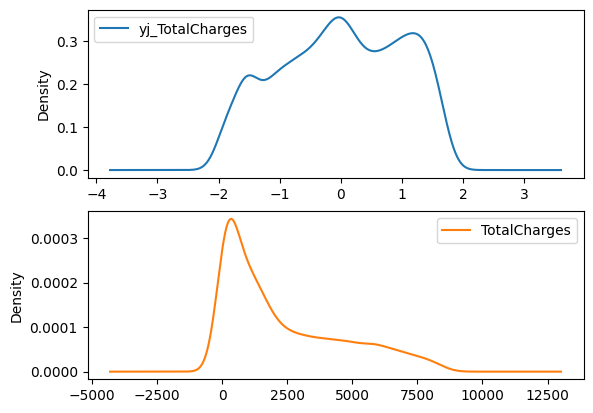

In [45]:
pt = PowerTransformer()
df['yj_TotalCharges'] = pt.fit_transform(df[['TotalCharges']])
df[['yj_TotalCharges', 'TotalCharges']].plot.density(subplots=True, sharex=False)

# Interpretation and Analysis

## Value Counts for PhoneService

The value counts for the PhoneService column are imporatant to understand the distribution of customers based on their PhoneService status.
There are 6361 customers who have phone service and 682 customers wo don't have phone service. This information provides a baseline understanding of the dataset's phone service distribution, which is essential for subsequent analyses related to customer retention and predictive modeling.

## Filtering Data

Data is filtered based on the tenure column. The original DataFrame df is filtered to include only rows where the tenure column is less than or equal to 30. The resulting DataFrame tenure_df contains a subset of the original data, focusing on customers with a tenure of 30 or less.

This subset of data can be analyzed to understand patterns or behaviors specific to customers with shorter tenure periods.

## Boxplot for Numeric Columns

The boxplot visually represents the distribution of numeric columns (tenure, MonthlyCharges, and TotalCharges).
The boxplot aids in visualizing the spread of data and potential extreme values.

## Handling Outliers

The function handle_outliers was applied to the MonthlyCharges, TotalCharges and tenure columns, and it detected and handled outliers. The output indicates that there were no outliers found in those columns based on the criteria of using the IQR method with 1.5 times the interquartile range.

## Missing Values Check and Handling

There are 11 missing values in the TotalCharges column and 72 in tenure.
Missing values are dropped using df.dropna(inplace=True).


## Categorical to Numeric Conversion

The Churn and PhoneService columns are converted to numeric. Converting categorical variables to numeric facilitates quantitative analysis and model training.

## Feature Engineering

Log transformation of TotalCharges and the creation of a new feature

```shell

TotalCharges_to_MonthlyCharges_Ratio - Ratio of MonthlyCharges to TotalCharges)
```
Feature engineering helps create additional relevant features that may improve the performance of predictive models. Log transformation is often used to handle skewed data, and the new ratios provide insights into the relationships between variables.

## Histogram for Feature Relationships

Visualizations are created to explore relationships for TotalCharges_to_MonthlyCharges_Ratio
Visualizing relationships helps in understanding patterns, correlations, and potential dependencies between features, aiding further analysis and model development.

## Advanced Outlier Detection - Boxplot Analysis

The boxplot for scaled numeric data, as part of advanced outlier detection, provides insights into the distribution of standardized values for different features. 
**Tenure**
The boxplot shows that most values are clustered around the median, with a few outliers at both ends. This suggests that while the majority of customers have similar tenure values, there are some extreme cases.

**PhoneService**

Being a binary variable (0 or 1), the boxplot here indicates that the values are concentrated at the extremes (0 and 1), with no apparent outliers.

**MonthlyCharges**

The boxplot for MonthlyCharges shows a relatively symmetric distribution with a few outliers on the higher side. This suggests that most customers have similar monthly charges, but there are some with significantly higher charges.

**TotalCharges**

Similar to MonthlyCharges, TotalCharges exhibit a symmetric distribution with a few outliers on the higher side. This implies that while most customers have similar total charges, there are outliers with exceptionally high total charges.

**Churn**

Being a binary variable (0 or 1), the boxplot for Churn indicates that the values are concentrated at the extremes (0 and 1), with no apparent outliers.

**MonthlyCharges_to_TotalCharges_Ratio**

The boxplot reveals a distribution of the ratio, showing the spread and presence of outliers. Most values are clustered around the median, but there are some customers with significantly different ratios, indicating potential variations in spending patterns.


## Value Counts for Contract and PaymentMethod

The value counts provide information about the distribution of customers based on the Contract and PaymentMethod columns. It shows the count of customers for each unique value.


## Yeo-Johnson Transform

The Yeo-Johnson transform is applied to the TotalCharges column. The transformed data is centered around 0 and standardized, making the distribution more symmetric and normal. The density plot shows the before-and-after comparison, highlighting the transformation's impact on the distribution.
